In [90]:
#!pip install seaborn
#!pip install openpyxl
#!pip install pmdarima

In [91]:

import pandas as pd
import numpy as np
import random as rd
import time
import csv
import seaborn as sbs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split ,GridSearchCV
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot
from pmdarima.arima import auto_arima
from pmdarima.arima import StepwiseContext
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
import yfinance as yf


In [92]:
# fix random seed for reproducibility
tf.random.set_seed(9)

In [93]:
path_name_results='../results/'
file_result = 'Result_ARIMA_IBM_stock_prices.csv'

In [94]:
# Define the stock symbol (IBM)
stock_symbol = "IBM"

# Define the start and end dates for the historical data
start_date = "2017-01-01"
end_date = "2023-09-21"

# Download historical data
dataset = yf.download(stock_symbol, start=start_date, end=end_date)

ds=pd.DataFrame()
ds['date']=dataset['Open'].index
ds['num_observations']=dataset['Open'].values
dataset=ds


[*********************100%%**********************]  1 of 1 completed


In [95]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1690 non-null   datetime64[ns]
 1   num_observations  1690 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.5 KB


In [96]:
#verifica se existe variáveis nulas 
dataset.isna().sum()

date                0
num_observations    0
dtype: int64

In [97]:
def salvar_resultado(nm_dataset, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duration):
  #Script to write training cycle results
  data = [nm_dataset, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duration]
  fields = ['Dataset','Best Params','n_time_steps','MSE', 'RMSE', 'MAE', 'MAPE','sMAPE','Duration']
  with open(f'{path_name_results}{file_result}', "a",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(data)  
  print(fields)
  print(data)
    
#Script to create the results file
def criar_arquivo_resultado():
  fields = ['Dataset','Best Params','n_time_steps','MSE', 'RMSE', 'MAE','MAPE','sMAPE','Duration']
  with open(f'{path_name_results}{file_result}', "w",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(fields)    

In [98]:
# convert an array of values into a dataset matrix
def create_matrix_dataset(dataset, n_time_steps=1):
 #transformação da série => janela deslizande com n_time_steps passo de tempo    
 #tratando o dataframe
 df = pd.DataFrame()
 df['date']=dataset['date']
 df['vl_0']=dataset['num_observations']

 #n_time_steps=12
 for n_step in range(1,n_time_steps+1,1):   
   df['vl_' + str(n_step)] = dataset['num_observations'].shift(n_step)
 df.dropna(inplace=True)
 return np.array(df.drop(columns=['date','vl_0'])), np.array(df['vl_0'])

# convert dataset values into a dataset matrix
def create_dataset(dataset, n_time_steps=1):
 #transformação da série => janela deslizande com n_time_steps passo de tempo    
 #tratando o dataframe
 df = pd.DataFrame()
 df['date']=dataset['date']
 df['vl_0']=dataset['num_observations']

 #n_time_steps=12
 for n_step in range(1,n_time_steps+1,1):   
   df['vl_' + str(n_step)] = dataset['num_observations'].shift(n_step)
 df.dropna(inplace=True)
 return df

In [99]:
  
def save_model(model,n_time_steps):
  # serialize model to JSON
  model_json = model.to_json()
  with open(f'{path_name_results}model_{n_time_steps}.json', "w") as json_file:
    json_file.write(model_json)

  # serialize weights to HDF5
  model.save_weights(f'{path_name_results}model_{n_time_steps}.h5')
  print("Saved model to disk")


In [100]:
def gera_resultado(y_test, predict,nm_dataset, resultado, n_time_steps, Duracao):
 #Mean Squared Error (Mean Squared Difference Between Estimated Values and Actual Values) - MSE
 MSE = mean_squared_error(y_test, predict)    
 #Square Root of Mean Error - RMSE
 RMSE = np.sqrt(mean_squared_error(y_test, predict))    
 #Mean Absolute Distance or Mean Absolute Error - MAE
 MAE= median_absolute_error(y_pred=predict, y_true = y_test) 
  
 #Calculate the MAPE (Mean Absolute Percentage Error)
 MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100   
  
 sMAPE = round(
 	np.mean(
 		np.abs(predict - y_test) /
 		((np.abs(predict) + np.abs(y_test)))
 	)*100, 2
 ) 
 salvar_resultado(nm_dataset, resultado, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duracao)
 return MAPE

array([<AxesSubplot:xlabel='date'>], dtype=object)

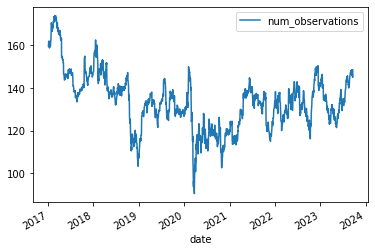

In [101]:
# indexing timestamp
dataset.set_index('date').plot(subplots=True)

In [102]:
def previsao_ARIMA(nm_dataset, dataset, n_time_steps, max_iter): 
    
 #Split dataset in treinam /  80% treinam  20% test
 nlinhas = int(len(dataset) * 0.80)
 test = dataset.iloc[nlinhas:len(dataset),:]  
 train = dataset.iloc[0:nlinhas,:] 
 #  reshape into X=t and Y=t+1 ot n_time_steps by steps
 X_train, Y_train = create_matrix_dataset(train, n_time_steps)
 X_test, Y_test = create_matrix_dataset(test, n_time_steps)  

 # indexing timeserires
 ts_df=create_dataset(dataset, n_time_steps)
 ts_df.set_index('date').plot(subplots=True) 

 Y_train = Y_train.reshape(-1,1)
 Y_test=Y_test.reshape(-1,1) 

 # Armazena a hora de início da execução do Treinamento
 Hora_Inicio = time.time() 

 # Estimate the differences number using ADF test
 # significance level alpha=0.05
 ADF_test = ADFTest(alpha=0.05)
 p_val, should_diff = ADF_test.should_diff(Y_train)   

 if(should_diff):  # if  should_diff is true 
     d = ndiffs(Y_train, test='adf') 
 else: # if  should_diff is False
     d=0 

 # autocorrelation test
 pm.plot_acf(Y_train) 

 # Search for best ARIMA hiperparams.
 with StepwiseContext(max_dur=50):
    model = auto_arima(Y_train, X = X_train,
                       seasonal=True, m=12, maxiter=500, d=0, 
                       start_p=0, start_q=0, max_p=9, max_q=9, 
                       D=None, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True) 

 #print(model.params)
 model.fit(Y_train)
 resultado = model 

 # predictiong values
 predict=model.predict(n_periods=Y_test.shape[0], X=X_test, alpha=0.05)
 predict=predict.reshape(-1,1) 

 Hora_Fim = time.time()    
 

 #print real x predict
 df_predict = pd.DataFrame(predict)
 new_df=pd.DataFrame()
 total=nlinhas+len(df_predict)
 new_df['real']=(dataset.iloc[0:total,1])
 new_df['date']=dataset.iloc[0:total,0]
 new_df['predict']=pd.concat([dataset.iloc[0:nlinhas,1],df_predict],ignore_index=True)
 new_df.set_index('date').plot() 

 #Calculate the duration of the training execution
 Duracao = Hora_Fim - Hora_Inicio    

 #calc metrics of error and save in file
 gera_resultado(Y_test, predict,nm_dataset, resultado, n_time_steps, Duracao)

forecast for IBM stock prices


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


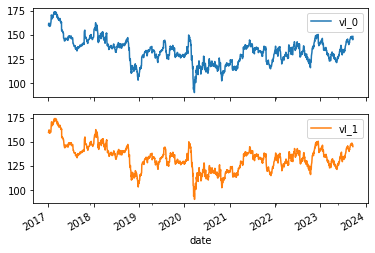

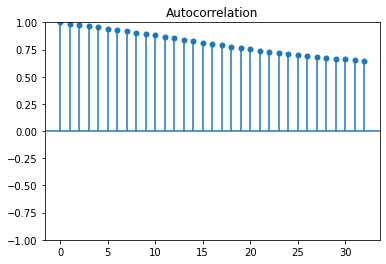

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5604.523, Time=3.27 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5600.891, Time=0.77 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5604.449, Time=3.35 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5604.424, Time=6.92 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5606.689, Time=1.25 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=5602.536, Time=3.24 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=5610.187, Time=1.17 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5602.850, Time=1.31 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=5602.860, Time=1.25 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=5603.113, Time=1.82 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 24.379 seconds
['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['IBM', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings

c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


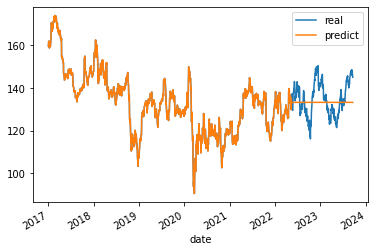

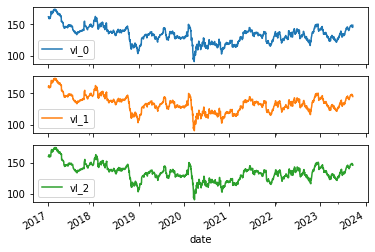

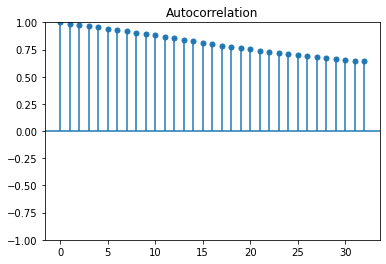

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5603.056, Time=6.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5599.420, Time=1.73 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5602.864, Time=4.53 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5602.933, Time=8.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5605.377, Time=1.44 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=5601.102, Time=4.24 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=5608.885, Time=1.67 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5601.231, Time=2.75 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=5601.352, Time=2.62 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=5599.027, Time=6.77 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=5600.384, Time=17.23 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=5600.372, Time=19.00 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=5603.080, Time=16.26 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=5609.673, Time=3.24 sec
 ARIMA(1,0,2)(0,

c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (117.520 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['IBM', ARIMA(maxiter=500, order=(1, 0, 1), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True), 2, 60.12862061946668, 7.754264673034232, 6.40506440521041, 4.895886249518261, 2.44, 120.25006794929504]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


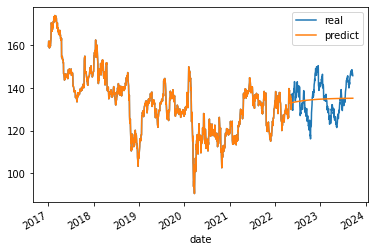

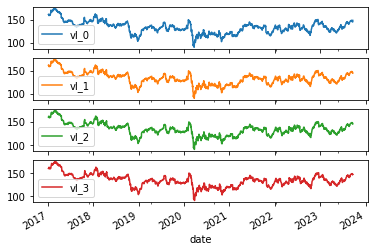

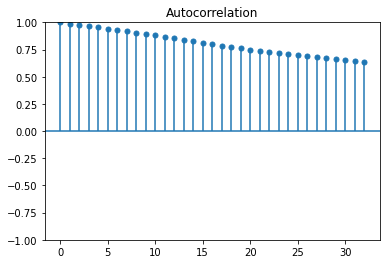

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5597.344, Time=14.29 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5593.929, Time=3.17 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5597.234, Time=12.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5606.231, Time=3.65 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5600.757, Time=3.16 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=5595.530, Time=10.26 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=5595.507, Time=16.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5595.657, Time=5.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=5604.554, Time=2.25 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=5606.555, Time=3.51 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 73.986 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (73.941 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['IBM', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True), 3, 63.092052594309, 7.943050584901811, 6.251938267758021, 4.898410206740457, 2.47, 77.57924056053162]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


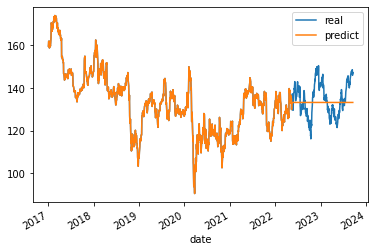

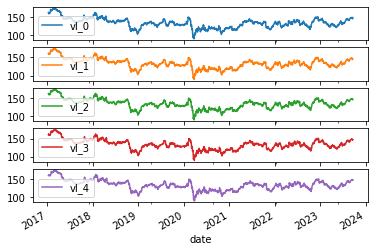

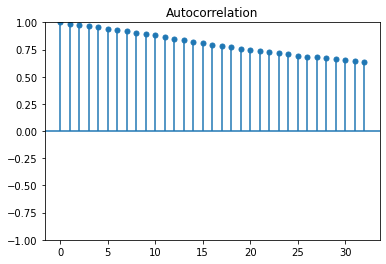

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5595.155, Time=19.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5591.615, Time=5.44 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5594.930, Time=20.37 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5594.941, Time=19.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5598.742, Time=5.79 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 70.465 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (70.399 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['IBM', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True), 4, 63.323308821940905, 7.957594411751638, 6.274997711181641, 4.907333882019356, 2.48, 78.34026575088501]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


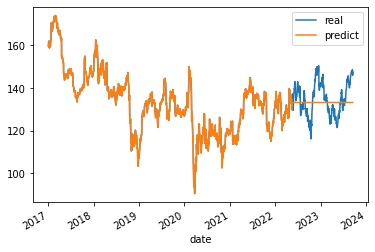

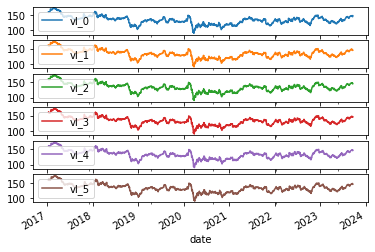

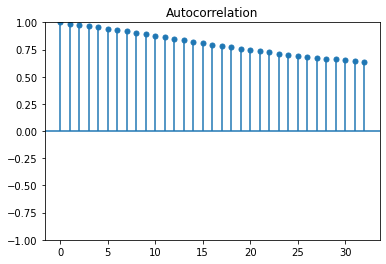

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5592.710, Time=23.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5589.324, Time=4.98 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5592.287, Time=20.41 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5601.617, Time=4.93 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5596.127, Time=3.72 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 57.525 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (57.488 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['IBM', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True), 5, 63.54603942602723, 7.971576972345386, 6.264176021086001, 4.914829443439469, 2.48, 62.833900451660156]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


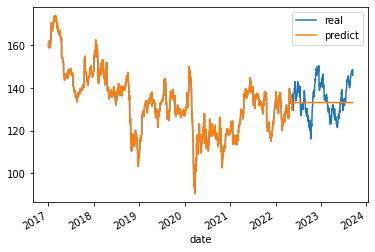

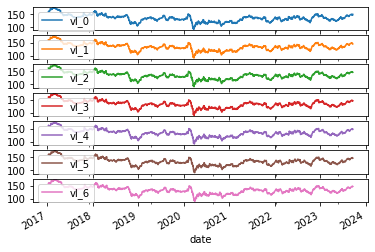

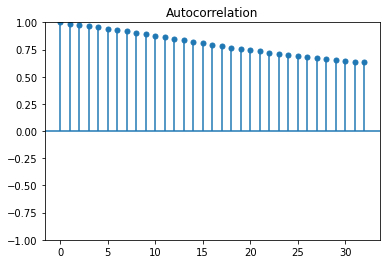

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5588.272, Time=37.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5584.754, Time=4.98 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5588.533, Time=23.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5597.504, Time=4.94 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5591.899, Time=4.56 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 74.753 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (74.706 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['IBM', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True), 6, 63.78835278408587, 7.986761094717049, 6.2649993896484375, 4.9249431611846815, 2.49, 80.52767300605774]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


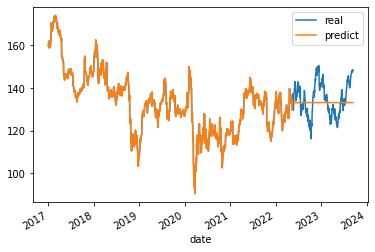

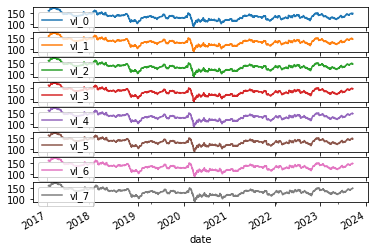

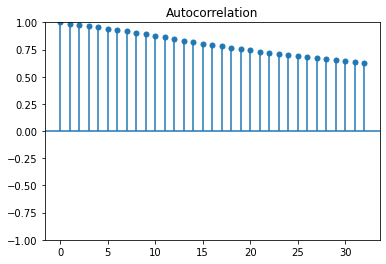

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5585.792, Time=47.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5582.286, Time=8.22 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5586.072, Time=30.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5595.201, Time=8.85 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5589.600, Time=10.31 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 105.051 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (105.017 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['IBM', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True), 7, 64.04819534785159, 8.003011642366365, 6.30360255471831, 4.940450227675895, 2.49, 111.29157209396362]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


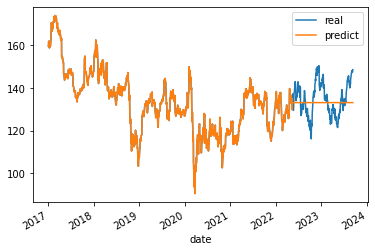

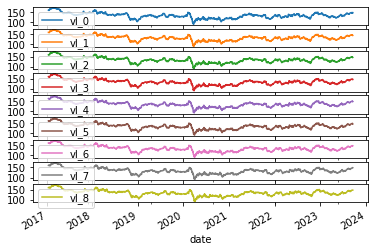

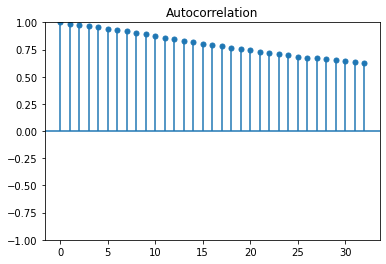

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5581.625, Time=33.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5578.253, Time=6.34 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5583.360, Time=23.02 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5591.942, Time=6.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5586.381, Time=3.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 72.542 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (72.450 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['IBM', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True), 8, 64.30410040999162, 8.018983751697693, 6.314998626708984, 4.952581301525184, 2.5, 79.90966582298279]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


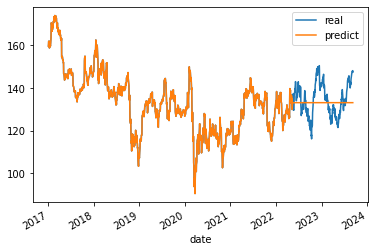

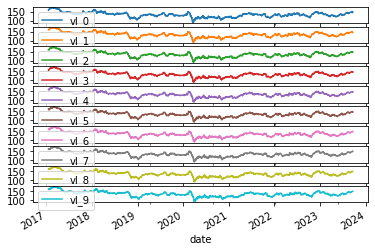

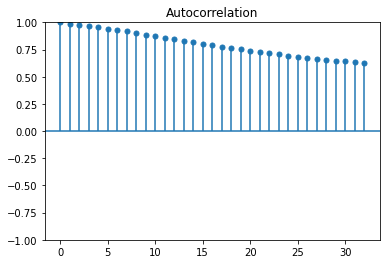

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5581.536, Time=25.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5576.980, Time=11.48 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5580.947, Time=32.00 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5590.682, Time=7.67 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5585.124, Time=8.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 84.897 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (84.852 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['IBM', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True), 9, 64.51722434140426, 8.032261471180098, 6.344363799844331, 4.9595695940564095, 2.5, 91.75285577774048]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


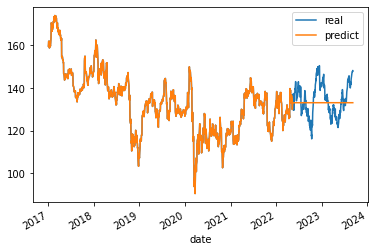

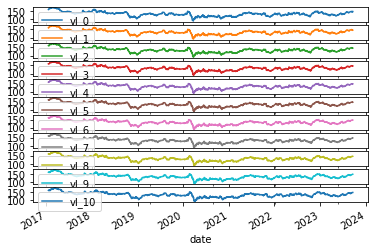

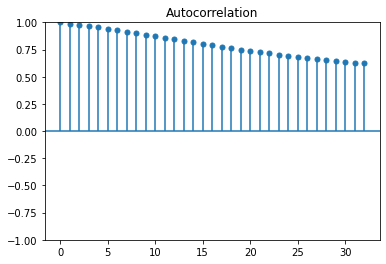

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5579.993, Time=32.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5575.364, Time=10.73 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5578.911, Time=42.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5588.671, Time=10.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5583.079, Time=15.31 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 111.262 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (111.227 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['IBM', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True), 10, 64.70479149421716, 8.043928859345858, 6.364997863769531, 4.964719125214416, 2.51, 119.9711046218872]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


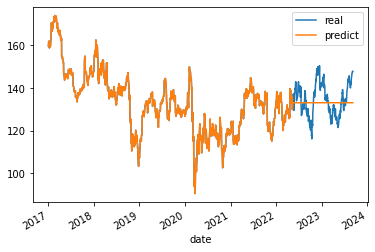

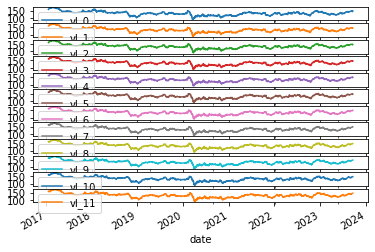

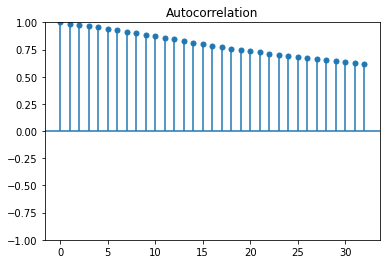

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5575.586, Time=55.23 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5572.086, Time=20.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5579.158, Time=39.43 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5586.097, Time=7.54 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5580.500, Time=5.33 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 127.653 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (127.532 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['IBM', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True), 11, 64.84209530151445, 8.05245895993978, 6.345889763544051, 4.966752880275696, 2.51, 136.67911648750305]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


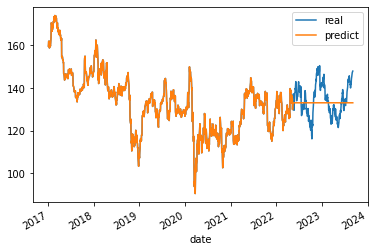

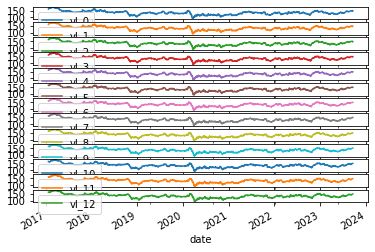

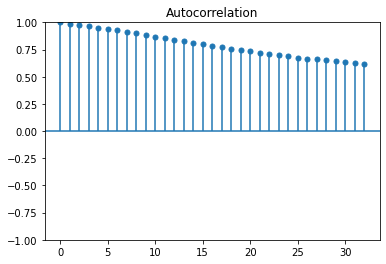

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5574.168, Time=72.28 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5570.898, Time=10.66 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5584.776, Time=5.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5575.230, Time=60.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5579.121, Time=9.36 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 157.832 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (157.794 > 50.000)
  warnings.warn('early termination of stepwise search due to '


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['IBM', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 12), suppress_warnings=True), 12, 64.98707795174937, 8.06145631705273, 6.3300018310546875, 4.969150971850623, 2.51, 166.87002515792847]


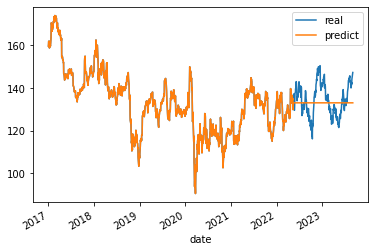

In [103]:
#create file to results
criar_arquivo_resultado()

print('forecast for IBM stock prices')
max_iter =500 # number of epochs for train


for n_time_steps in range(1,13): #predict with 1 to 12 past values of medition 
   previsao_ARIMA('IBM', dataset, n_time_steps, max_iter)